# Assignment Day 5

## Team members:
- Samuel Nebgen s6sanebg@uni-bonn.de
- Muhammad Humza Arain s27marai@uni-bonn.de
- Julian Meigen s82jmeig@uni-bonn.de

## 12.09.2025

Contributions were made by all team members in around the same amount, either based on discussions or coding.

# Predicting Time-To-Event for a Breast Cancer Data Set

This notebook provides the tasks of predicting the time-to-event for a breast cancer dataset. The dataset is originally from [here](https://archive.ics.uci.edu/dataset/16/breast+cancer+wisconsin+prognostic), but a formatted version is available in the Github repository.

The dataset contains numerous patient characteristics and an indicator of whether or not the cancer has recurred. The task is to predict the time-to-event for the patients.

The main tasks are: 

- Load the dataset & explore the data
- Plot Kaplan-Meier survival curves
- Fit a Cox proportional hazards model
- Implement a DeepSurv model
- Compare model performance

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import torch

In [14]:
available_columns = [
    "id",
    "outcome",
    "time",
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave_points_mean",
    "symmetry_mean",
    "fractal_dimension_mean",
    "radius_se",
    "texture_se",
    "perimeter_se",
    "area_se",
    "smoothness_se",
    "compactness_se",
    "concavity_se",
    "concave_points_se",
    "symmetry_se",
    "fractal_dimension_se",
    "radius_worst",
    "texture_worst",
    "perimeter_worst",
    "area_worst",
    "smoothness_worst",
    "compactness_worst",
    "concavity_worst",
    "concave_points_worst",
    "symmetry_worst",
    "fractal_dimension_worst",
    "tumor_size",
    "lymph_node_status",
]

## Task 1: Load the dataset & explore the data

The data set is available in the Github repository. Load the dataset and look at the features. You can look at some features and see if they are associated with recurrence or not.

In [19]:
data= pd.read_csv(os.path.join('..', 'data', 'raw', 'wpbc.data'), header=None, names=available_columns, index_col='id')


data.head()

,outcome,time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,tumor_size,lymph_node_status
id,,,,,,,,,,,,,,,,,,,,,
119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,...,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,...,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0


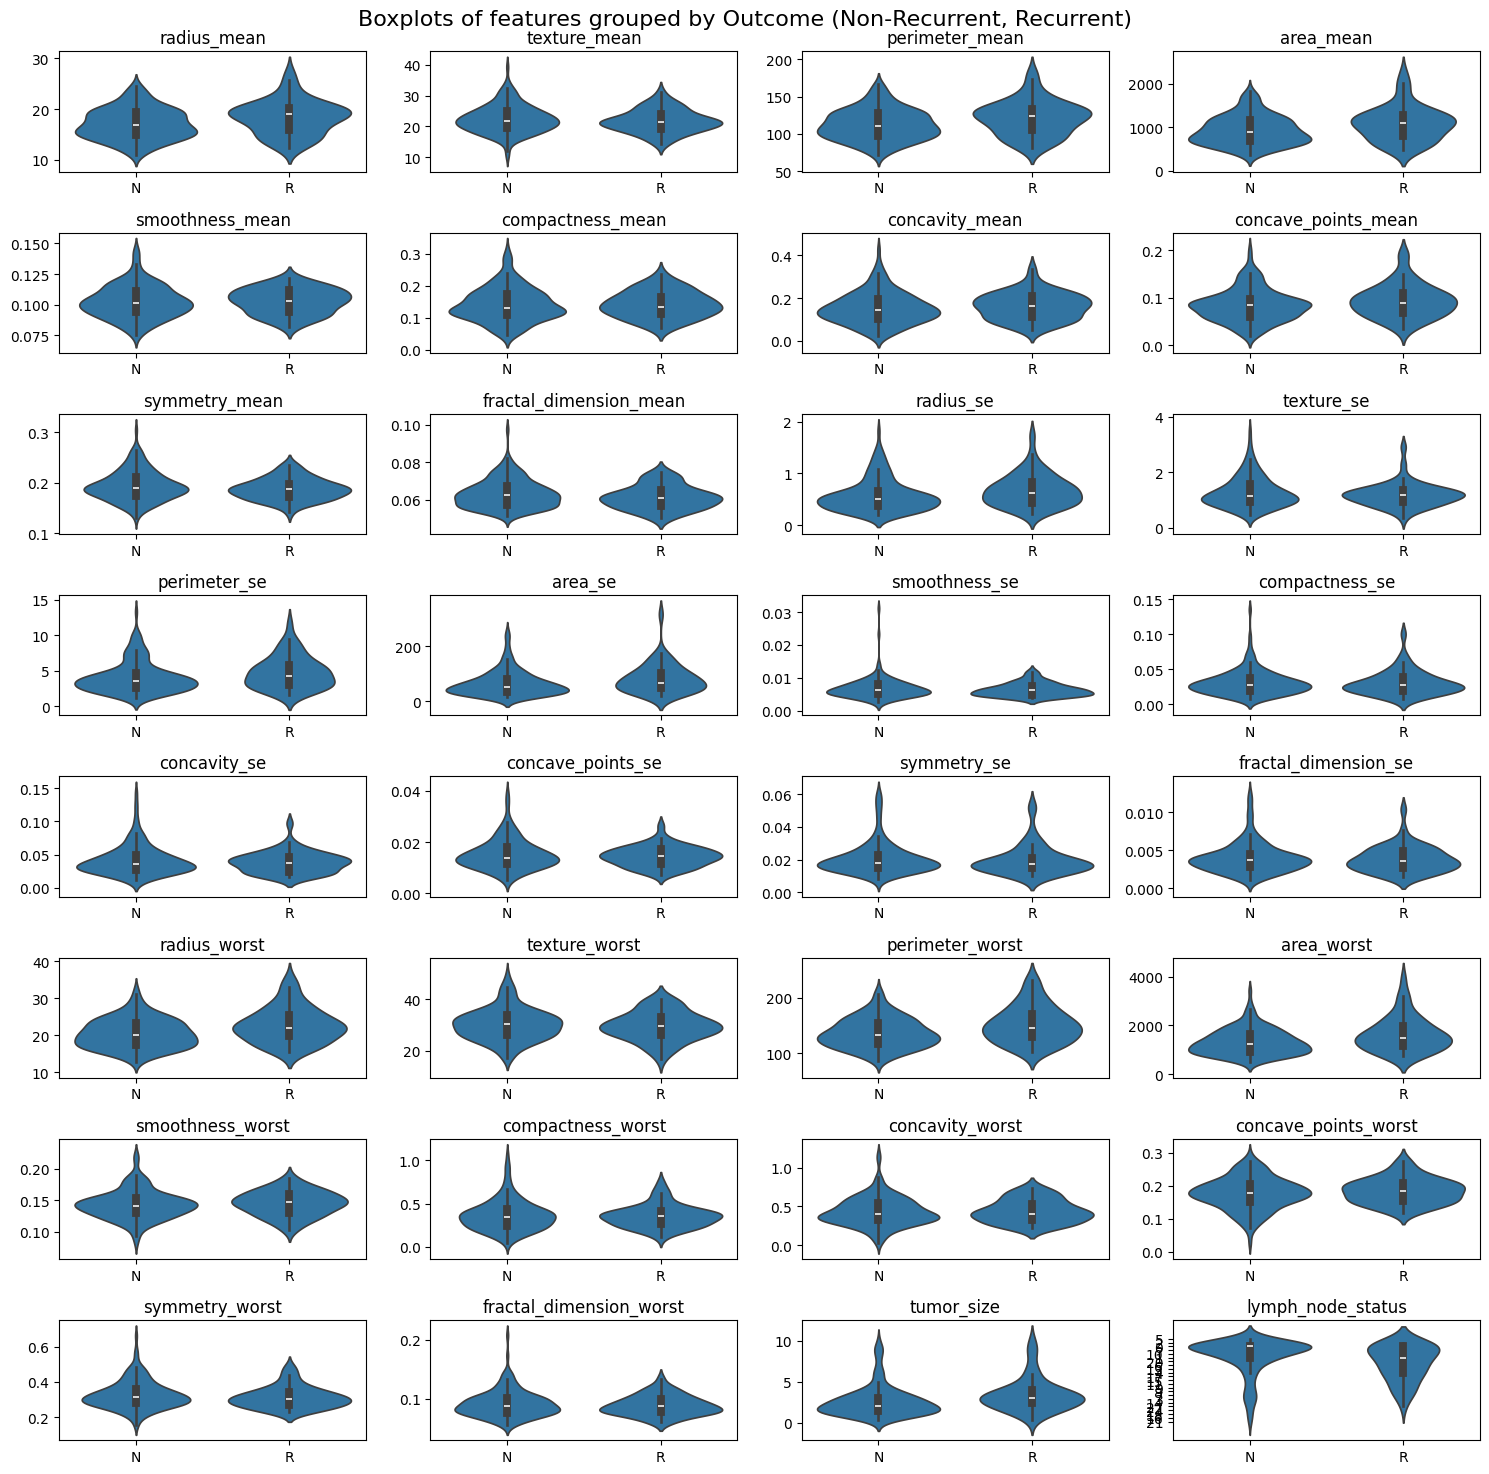

In [33]:
# try and do a mean whitney u test on the data to see if there are variables that are significantly different between the two classes
# but first plot the boxplots of all the variables 

fig, axes = plt.subplots(8,4, figsize=(15,15))
for i, col in enumerate(data.columns[2:]):
    sns.violinplot(x=data["outcome"], y=data[col], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)
    axes[i//4, i%4].set_xlabel("")
    axes[i//4, i%4].set_ylabel("")
fig.suptitle("Boxplots of features grouped by Outcome (Non-Recurrent, Recurrent)", fontsize=16)
plt.tight_layout()

In [25]:
# now doing the mann whitney u test
from scipy.stats import mannwhitneyu
significant_vars = []
for col in data.columns[2:32]:
    group1 = data[data["outcome"] == 'N'][col]
    group2 = data[data["outcome"] == 'R'][col]
    stat, p = mannwhitneyu(group1, group2)
    if p < 0.05:
        significant_vars.append(col)
        print(f"{col}: U-statistic={stat}, p-value={p}")



radius_mean: U-statistic=2760.5, p-value=0.02170323266364902
perimeter_mean: U-statistic=2745.5, p-value=0.01932307306603115
area_mean: U-statistic=2714.0, p-value=0.015055171976655577
radius_se: U-statistic=2770.0, p-value=0.023340805922652166
perimeter_se: U-statistic=2775.0, p-value=0.02424410856576506
area_se: U-statistic=2717.5, p-value=0.015484556253994426
radius_worst: U-statistic=2552.5, p-value=0.0037099504859011362
perimeter_worst: U-statistic=2585.0, p-value=0.0049991788397547735
area_worst: U-statistic=2550.5, p-value=0.0036416630895414926


In [26]:
from scipy.stats import ttest_ind

significant_vars_ttest = []
for col in data.columns[2:32]:
    group1 = data[data["outcome"] == 'N'][col]
    group2 = data[data["outcome"] == 'R'][col]
    stat, p = ttest_ind(group1, group2)
    if p < 0.05:
        significant_vars_ttest.append(col)
        print(f"{col}: t-statistic={stat}, p-value={p}")

radius_mean: t-statistic=-2.4755494025176885, p-value=0.014151431734283742
perimeter_mean: t-statistic=-2.51020989392295, p-value=0.012874839955837375
area_mean: t-statistic=-2.707764835446465, p-value=0.007372496899567576
perimeter_se: t-statistic=-2.0030571162370077, p-value=0.0465488453798921
area_se: t-statistic=-2.1504929524772716, p-value=0.03274080823224723
radius_worst: t-statistic=-3.3577489371112406, p-value=0.0009439852805053054
perimeter_worst: t-statistic=-3.33907981513205, p-value=0.001006064853118334
area_worst: t-statistic=-3.3895094039039533, p-value=0.0008465204467802073


## Task 2: Generate Kaplan-Meier Survival Curves

Kaplan-Meier survival curves are a good way to visualize survival data. Generate the Kaplan-Meier survival curves for the data set. You can use the `lifelines' library for this task.

You should generate the survival curves for the following characteristics

- Tumor size (greater or less than the median)
- Number of lymph nodes (0, <5, >=5)
- Recurrence-free survival (RFS)

You can also generate the survival curves for the features you consider important.

## Task 3: Fit a Cox Proportional Hazards model

The Cox Proportional Hazards model is a popular model for predicting time-to-event. Fit a Cox Proportional Hazards model to the data set. You can use the `lifelines' library for this task.

You should perform cross-validation to evaluate the performance of the model. You can use the C-index as an evaluation metric. See the documentation of the `lifelines' library to see how to perform a cross-validation. Finally, generate a boxplot of the C-index values.

## Task 4: Implement a DeepSurv model

DeepSurv is a deep learning model for time-to-event prediction. Implement this model, evaluate its performance using cross-validation, and generate a box plot of the C-index values.

1. First, you need to create an appropriate **Dataset** class that returns the features, the time-to-event, and the event indicator.
2. Then you need a neural network model that takes the features as input and returns the predicted hazard ratio.
3. You need to implement a training and evaluation loop for the model. As a loss function, you can use the `neg_partial_log_likelihood` from the `torchsurv` library.
4. You need to put everything together and run a cross-validation to evaluate the performance of the model. Evaluate the performance in each fold using the C-index.

Notes: 
- Remember to scale the features before feeding them into the model.
- Do not optimize the hyperparameters of the model. In this case, you would need to implement nested cross-validation, which is beyond the scope of this notebook. You can use a learning rate of 0.01 and 50 epochs for training. If your model does not perform well, try using two linear layers of 32 units each and a ReLU activation function. The final output dimension should be 1.

## Task 5: Describe your results



## Optional

- Add a feature selection method to the Cox Proportional Hazards model.
- Attempt to implement nested cross-validation to optimize the hyperparameters of the DeepSurv model.